In [1]:
import os
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import sys
sys.path.append("/Users/seungminjang/Desktop/workspace/recsys")

In [2]:
class MovielensDataset(torch.utils.data.Dataset):
    def __init__(self, data, sparse_feature_names):
        self.sparse_feature_names = sparse_feature_names
        self.data = data[:, :-1]
        self.label = data[:, [-1]].astype(float)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            self.sparse_feature_names[0]: self.data[idx, 0],
            self.sparse_feature_names[1]: self.data[idx, 1],
        }, self.label[idx]
        
class MovielensMatrixFactorization(torch.nn.Module):
    def __init__(
        self,
        num_sparse_features: dict[str, int],
        latent_dim: int,
    ):
        super().__init__()
        self.num_sparse_features = num_sparse_features
        self.latent_dim = latent_dim
        self.sparse_feature_names = list(num_sparse_features.keys())

        self.embeddings = torch.nn.ModuleDict({
            name : torch.nn.Embedding(num_sparse_feature, latent_dim)
            for name, num_sparse_feature in num_sparse_features.items()
        })
        
    def forward(self, sparse_features: dict[str, torch.LongTensor]) -> torch.FloatTensor:
        emb1 = self.embeddings[self.sparse_feature_names[0]](sparse_features[self.sparse_feature_names[0]])
        emb2 = self.embeddings[self.sparse_feature_names[1]](sparse_features[self.sparse_feature_names[1]])
        logits = (emb1 * emb2).sum(dim=1, keepdim=True)
        return logits

In [3]:
ratings = pd.read_csv("movielens/raw/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
users = pd.read_csv("movielens/raw/u.user", sep="|", encoding="latin-1", names=["user_id", "age", "gender", "occupation", "zip"])
items = pd.read_csv("movielens/raw/u.item", sep="|", encoding="latin-1", names=[
        "item_id",
        "title",
        "release_date",
        "video_release_date",
        "imdb_url",
        "unknown",
        "action",
        "adventure",
        "animation",
        "children",
        "comedy",
        "crime",
        "documentary", 
        "drama", 
        "fantasy",
        "film-noir",
        "horror",
        "musical",
        "mystery",
        "romance",
        "sci-Fi",
        "thriller",
        "war",
        "western",
    ])
num_sparse_features = {
    "user_id": users["user_id"].nunique(),
    "item_id": items["item_id"].nunique(),
}
vocabulary = {
    "user_id": np.unique(users["user_id"]),
    "item_id": np.unique(items["item_id"])
}

In [4]:
# 전처리
processed = ratings.copy()

# user_id, item_id 정보가 있는 데이터만 남기기
processed = processed[(
    processed["user_id"].isin(vocabulary["user_id"])
    & processed["item_id"].isin(vocabulary["item_id"])
)]
unknown = len(ratings) - len(processed)
print("삭제된 알 수 없는 데이터:", unknown)


# user_id, item_id를 index 매핑
processed["user_id"] = processed["user_id"].map({
    uid : i 
    for i, uid in enumerate(vocabulary["user_id"])
})

processed["item_id"] = processed["item_id"].map({
    iid : i 
    for i, iid in enumerate(vocabulary["item_id"])
})

삭제된 알 수 없는 데이터: 0


In [5]:
# Dataset Hyperparameter
maximum_positive_sample = 100
num_negative_sample = 5
all_item_indices = np.arange(num_sparse_features["item_id"])

# Leave-one-out split
# Downsampling
# Random Negative Sampling
train, test = [], []
for u, group in tqdm(processed.sort_values(by="timestamp").groupby("user_id")):
    # Leave one
    last = group.iloc[-1, :2].values
    test.append([last[0], last[1], 1])
    
    
    # Downsampling
    group = group.iloc[:-1]
    num_positive_sample = len(group)
    num_positive_sample = min(maximum_positive_sample, num_positive_sample)
    group = group.tail(num_positive_sample)

    # positive samples
    positive = group[["user_id", "item_id"]].values
    positive = np.column_stack([positive, np.ones(len(positive), dtype=int)])

    # negative sampling
    positive_item_indices = group["item_id"].unique()
    negative_item_indices = np.setdiff1d(all_item_indices, positive_item_indices)

    size = num_positive_sample*num_negative_sample
    replace_flag = size > len(negative_item_indices)
    negative_item_indices = np.random.choice(
        negative_item_indices,
        size=size,
        replace=replace_flag
    )

    negative = np.column_stack([
        np.full(size, u, dtype=int),
        negative_item_indices,
        np.zeros(size, dtype=int)
    ])
    train.append(positive)
    train.append(negative)

train = np.vstack(train)
test = np.vstack(test)

# save in processed
np.save("movielens/processed/train.npy", train)
np.save("movielens/processed/test.npy", test)

100%|███████████████████████████████████████| 943/943 [00:00<00:00, 2466.83it/s]


In [6]:
# Training Hyperparameter
batch_size = 64
latent_dim = 16
lr = 1e-3
epochs = 20

# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
model = MovielensMatrixFactorization(num_sparse_features, latent_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
# Train MF
history = defaultdict(list)
model.train()
auc = 0
for epoch in range(epochs):
    total_loss = 0
    all_labels = []
    all_preds = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for sparse_features, labels in pbar:
        sparse_features = {k: v.to(device) for k, v in sparse_features.items()}
        labels = labels.to(device)

        
        # forward
        logits = model(sparse_features)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # metrics
        total_loss += loss.item()
        probs = logits.sigmoid().detach().cpu().numpy()
        all_preds.extend(probs.flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten())
        
        # tqdm update
        pbar.set_postfix(
            logloss=loss.item(),
            auc=f"{auc:.4f}"
            
        )

        
    avg_loss = total_loss / len(train_loader)
    acc = ((np.array(all_preds) > 0.5) == np.array(all_labels)).mean()
    auc = roc_auc_score(all_labels, all_preds)
    history["accuracy"].append(acc)
    history["auroc"].append(auc)
    history["logloss"].append(avg_loss)
    
    pbar.set_postfix(
        logloss=f"{avg_loss:.4f}",
        auc=f"{auc:.4f}"
    )
    pbar.refresh()

Epoch 1/20: 100%|█| 5747/5747 [00:08<00:00, 649.58it/s, auc=0.0000, logloss=1.72
Epoch 2/20: 100%|█| 5747/5747 [00:09<00:00, 617.30it/s, auc=0.4996, logloss=1.46
Epoch 3/20: 100%|█| 5747/5747 [00:10<00:00, 572.90it/s, auc=0.5101, logloss=1.24
Epoch 4/20: 100%|█| 5747/5747 [00:09<00:00, 589.49it/s, auc=0.5237, logloss=1.06
Epoch 5/20: 100%|█| 5747/5747 [00:09<00:00, 578.05it/s, auc=0.5421, logloss=0.89
Epoch 6/20: 100%|█| 5747/5747 [00:10<00:00, 561.75it/s, auc=0.5696, logloss=0.71
Epoch 7/20: 100%|█| 5747/5747 [00:09<00:00, 578.09it/s, auc=0.6114, logloss=0.53
Epoch 8/20: 100%|█| 5747/5747 [00:09<00:00, 577.17it/s, auc=0.6660, logloss=0.37
Epoch 9/20: 100%|█| 5747/5747 [00:10<00:00, 545.96it/s, auc=0.7223, logloss=0.27
Epoch 10/20: 100%|█| 5747/5747 [00:10<00:00, 572.06it/s, auc=0.7701, logloss=0.2
Epoch 11/20: 100%|█| 5747/5747 [00:11<00:00, 519.06it/s, auc=0.8051, logloss=0.2
Epoch 12/20: 100%|█| 5747/5747 [00:12<00:00, 445.86it/s, auc=0.8283, logloss=0.1
Epoch 13/20: 100%|█| 5747/57

In [8]:
# TopK recommendation
topk = 10

user_recommendations = {}
model.eval()
with torch.no_grad():
    all_item_indices = torch.arange(num_sparse_features["item_id"]).to(device)
    pbar = tqdm(range(num_sparse_features["user_id"]), desc="TopK Recommend")
    for user_id in pbar:
        sparse_features = {
            "user_id":torch.full(size=(len(all_item_indices),), fill_value=user_id).to(device),
            "item_id":all_item_indices,
        }
        logits = model(sparse_features)
        indices = logits.flatten().argsort(descending=True)
        

        user_recommendations[user_id] = indices.detach().cpu().numpy()

        pbar.set_postfix(user_id=user_id)
        
# 대조군(Popular)
test_data = processed.sort_values(by="timestamp").groupby("user_id").tail(1)
train_data = processed.drop(test_data.index)    
popular_recommendations = train_data["item_id"].value_counts().index.values

# 대조군(Random)
all_item_indices = all_item_indices.numpy()
random_recommendations = np.random.choice(all_item_indices, size=len(all_item_indices), replace=False)

TopK Recommend: 100%|██████████| 943/943 [00:00<00:00, 1455.21it/s, user_id=942]


In [9]:
import numpy as np

def hit_ratio_at_k(recs: np.ndarray, real: int, k: int) -> float:
    return 1.0 if real in recs[:k] else 0.0


def ndcg_at_k(recs: np.ndarray, real: int, k: int) -> float:
    recs_k = recs[:k]
    idx = np.where(recs_k == real)[0]
    if len(idx) > 0:
        rank = idx[0] + 1  # 1-based
        return 1.0 / np.log2(rank + 1)
    return 0.0


def mrr_at_k(recs: np.ndarray, real: int, k: int) -> float:
    recs_k = recs[:k]
    idx = np.where(recs_k == real)[0]
    if len(idx) > 0:
        rank = idx[0] + 1
        return 1.0 / rank
    return 0.0


In [11]:
ks = [5, 10, 15, 20]
hr = defaultdict(float)
ndcg = defaultdict(float)
mrr = defaultdict(float)
for _, line in test_data.iterrows():
    user_id, item_id = line.user_id, line.item_id
    
    recs = user_recommendations[user_id]

    # calculate
    for k in ks:
        hr[f"mf@{k}"] += hit_ratio_at_k(recs, item_id, k)
        hr[f"popular@{k}"] += hit_ratio_at_k(popular_recommendations, item_id, k)
        hr[f"random@{k}"] += hit_ratio_at_k(random_recommendations, item_id, k)
    
        ndcg[f"mf@{k}"] += ndcg_at_k(recs, item_id, k)
        ndcg[f"popular@{k}"] += ndcg_at_k(popular_recommendations, item_id, k)
        ndcg[f"random@{k}"] += ndcg_at_k(random_recommendations, item_id, k)
    
        mrr[f"mf@{k}"] += mrr_at_k(recs, item_id, k)
        mrr[f"popular@{k}"] += mrr_at_k(popular_recommendations, item_id, k)
        mrr[f"random@{k}"] += mrr_at_k(random_recommendations, item_id, k)
    
hr = {k: np.round(v/len(test_data), 4) for k,v in hr.items()}
ndcg = {k: np.round(v/len(test_data), 4) for k,v in ndcg.items()}
mrr = {k: np.round(v/len(test_data), 4) for k,v in mrr.items()}

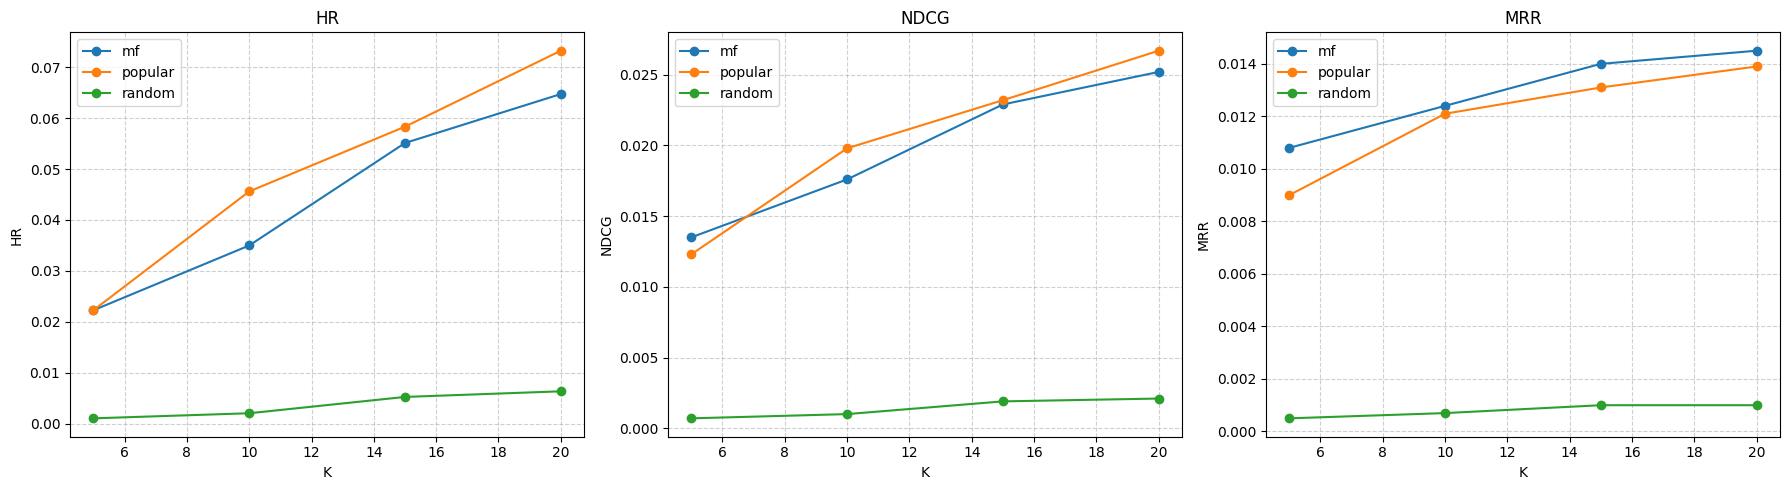

In [12]:
import matplotlib.pyplot as plt

metrics = {"HR": hr, "NDCG": ndcg, "MRR": mrr}
models = ["mf", "popular", "random"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, (metric_name, metric_dict) in zip(axes, metrics.items()):
    for model in models:
        values = [metric_dict[f"{model}@{k}"] for k in ks]
        ax.plot(ks, values, marker="o", label=model)

    ax.set_title(metric_name)
    ax.set_xlabel("K")
    ax.set_ylabel(metric_name)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()